#PyTorch Workflow

In [ ]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preparing and loading Data

In [ ]:
# create some known data using linear regression formula
#y=a+bX
#a = bias
#b = weight

weight=0.7
bias=0.3

start=0
end=1
step=0.02
X= torch.arange(start, end, step).unsqueeze(dim=1)
y=bias+ weight*X

len(X), len(y), X.shape, y.shape



(50, 50, torch.Size([50, 1]), torch.Size([50, 1]))

## Train/Test Split

In [ ]:
train_split=int(0.8*len(X))  # split into 80% training, 20% test
X_train, y_train=X[:train_split], y[:train_split]
X_test, y_test= X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=6, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="y", s=6, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=6, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

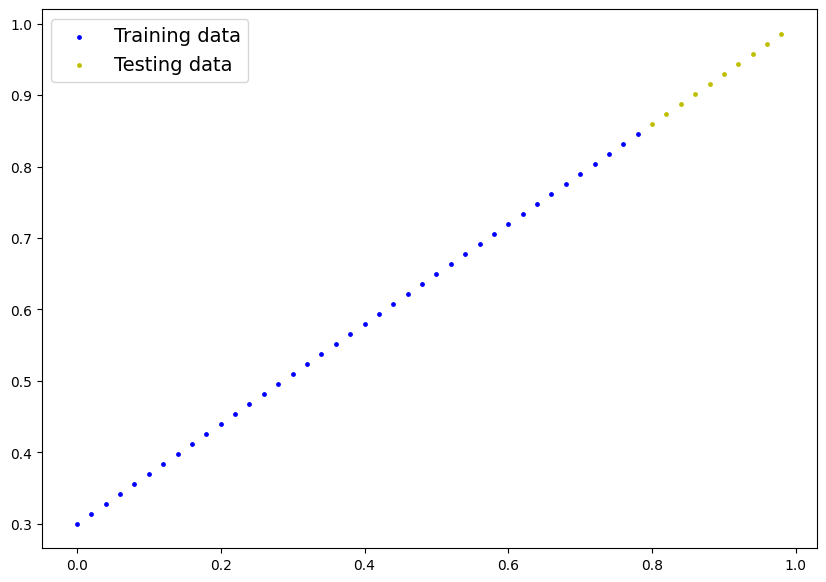

In [ ]:
plot_predictions();

## Building a Model

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # <- start with a random weight and try to adjust it to the ideal weight
    self.bias=nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) # <- start with a random bias and try to adjust it to the ideal bias

  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights*x+ self.bias #the linear regression formula


### Checking content of pyTorch model

In [ ]:
torch.manual_seed(42)

#create an instance of the model
model_0=LinearRegressionModel()

#check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions using `torch.inference_mode() `

In [ ]:
# make predictions

with torch.inference_mode():
  y_preds=model_0(X_test)

# similar way of making predictions
with torch.no_grad():
  y_preds=model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

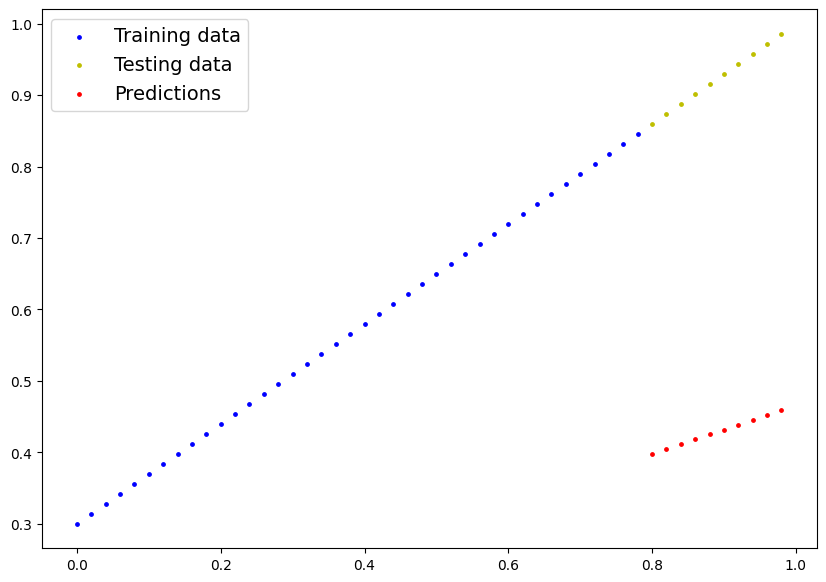

In [ ]:
#plot predictions
plot_predictions(predictions=y_preds)

## Training the model

In [ ]:
# setup a loss function
loss_fn=nn.L1Loss()

#setup an optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Building a training and testing loop

In [ ]:
torch.manual_seed(42)
epochs=100

epoch_count = []
loss_values = []
test_loss_values = []

# ---training loop---
#loop through data
for epoch in range(epochs):
  #set model to training mode
  model_0.train()

  # forward pass
  y_pred=model_0(X_train)

  #calculate loss
  loss=loss_fn(y_pred, y_train)
  print(f"loss = {loss}")

  #optimizer zero grad
  optimizer.zero_grad()

  #perform backpropagation
  loss.backward()

  #perform gradient descent
  optimizer.step()

  # ---Testing loop---
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes - https://twitter.com/PyTorch/status/1437838231505096708?s=20&t=aftDZicoiUGiklEP179x7A
  # with torch.no_grad(): # you may also see torch.no_grad() in older PyTorch code
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


  #print model state_dict()
  print(model_0.state_dict())

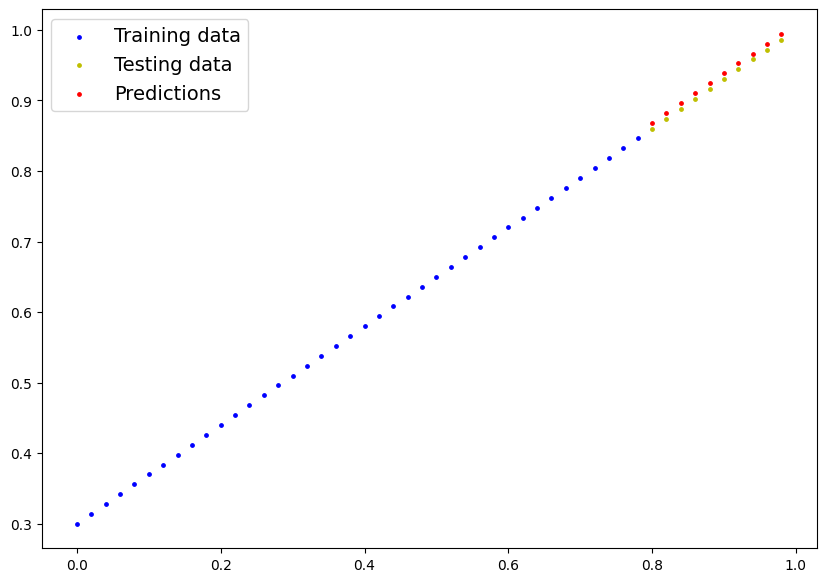

In [ ]:
with torch.inference_mode():
  y_preds=model_0(X_test)

plot_predictions(predictions=y_preds)

In [ ]:
np.array(torch.tensor(loss_values).numpy()), test_loss_values

(array([0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
        0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
       dtype=float32),
 [tensor(0.0565),
  tensor(0.0482),
  tensor(0.0406),
  tensor(0.0323),
  tensor(0.0241),
  tensor(0.0165),
  tensor(0.0082),
  tensor(0.0050),
  tensor(0.0050),
  tensor(0.0050)])

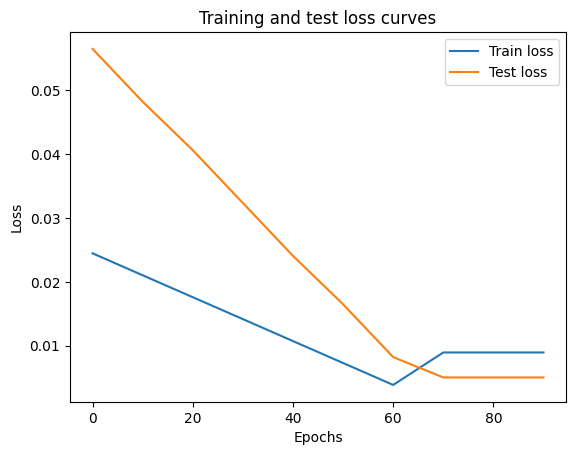

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### saving a model in PyTorch

In [ ]:
# saving a model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


### loading a pyTorch model

In [ ]:
# load in a saved state_dict by creating a new instance of the model class
loaded_model_0=LinearRegressionModel()

#load in saved_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

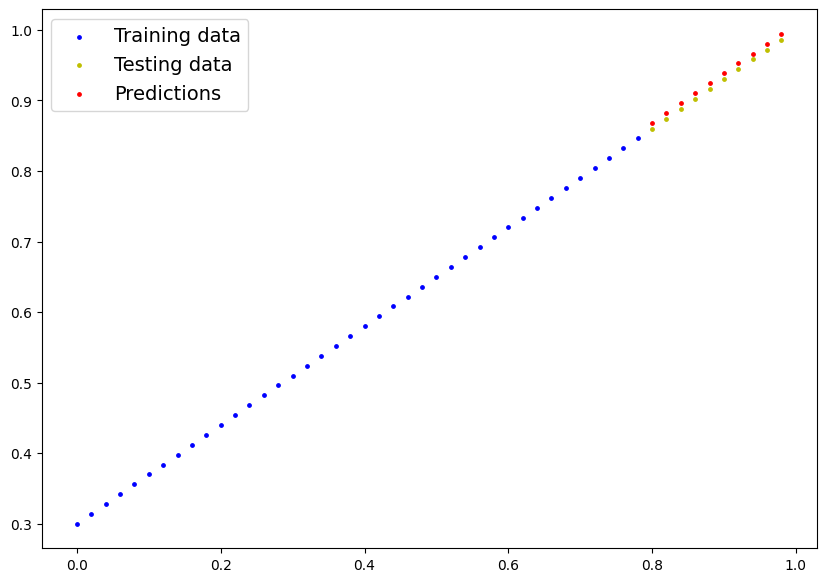

In [ ]:
plot_predictions(predictions=loaded_model_preds)

## End to end example

###1. Data

In [ ]:
#setup device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cuda


In [ ]:
#known parameters
weight= 0.75
bias=0.25

#create some data
start=0
end=1
step=0.02

X=torch.arange(start, end, step).unsqueeze(dim=1)
y=weight*X+bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.2500],
         [0.2650],
         [0.2800],
         [0.2950],
         [0.3100],
         [0.3250],
         [0.3400],
         [0.3550],
         [0.3700],
         [0.3850]]))

In [ ]:
# split data into training and testing

split_size=int(0.8*len(X)) #80% train / 20% test
X_train, y_train=X[:split_size], y[:split_size]
X_test, y_test=X[split_size:], y[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [ ]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):

  plt.figure(figsize=(10, 7))

  #plot training data
  plt.scatter(train_data, train_labels, c="b", s=6, label="Training data")

   #plot test data
  plt.scatter(test_data, test_labels, c="y", s=6, label="Test data")

  if predictions is not None:
    #plot predictions
    plt.scatter(test_data, predictions, c="r", s=6, label="prdictions")

  plt.legend(prop={"size":14})

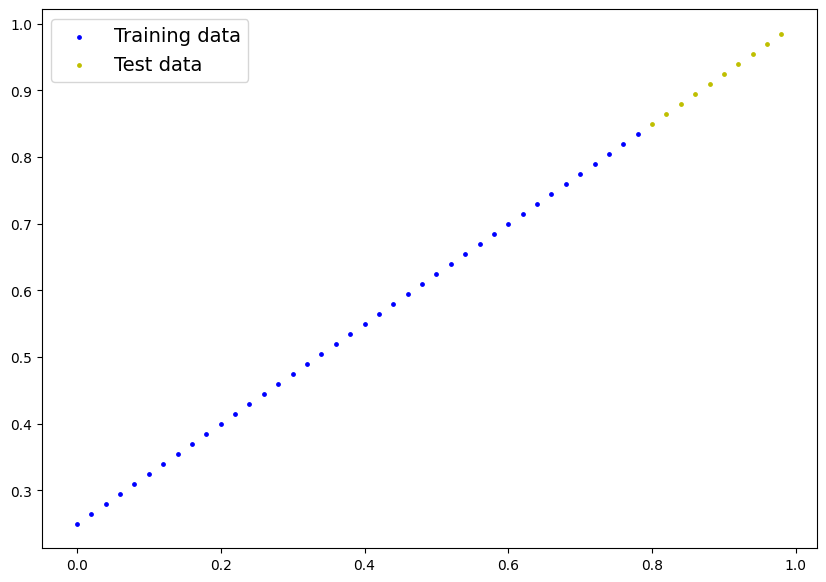

In [ ]:
plot_predictions()

### 2. Building a PyTorch Linear Model

In [ ]:
class LinearRegressionModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer=nn.Linear(in_features=1, out_features=1) # linear layer

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

In [ ]:
torch.manual_seed(42)

#create model instance
model_1=LinearRegressionModel2()

#check state_dict()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [ ]:
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 3. Training

In [ ]:
#define loss function
loss_fn=nn.L1Loss() #L1 loss is the same as MAE

#define optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
# Create a training and testing loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5856779217720032 | Test loss: 0.5794762969017029
Epoch: 10 | Loss: 0.47046804428100586 | Test loss: 0.44476643204689026
Epoch: 20 | Loss: 0.35525819659233093 | Test loss: 0.3100565969944
Epoch: 30 | Loss: 0.24004831910133362 | Test loss: 0.1753467321395874
Epoch: 40 | Loss: 0.1248384490609169 | Test loss: 0.04063691571354866
Epoch: 50 | Loss: 0.03964972123503685 | Test loss: 0.06165752559900284
Epoch: 60 | Loss: 0.03264206275343895 | Test loss: 0.07232307642698288
Epoch: 70 | Loss: 0.029130568727850914 | Test loss: 0.06748494505882263
Epoch: 80 | Loss: 0.02569580078125 | Test loss: 0.059212397783994675
Epoch: 90 | Loss: 0.022257069125771523 | Test loss: 0.051626741886138916
Epoch: 100 | Loss: 0.018828630447387695 | Test loss: 0.04335419461131096
Epoch: 110 | Loss: 0.015392175875604153 | Test loss: 0.0350816510617733
Epoch: 120 | Loss: 0.0119551420211792 | Test loss: 0.027496004477143288
Epoch: 130 | Loss: 0.008526702411472797 | Test loss: 0.01922345720231533
Epoch: 1

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7494]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2585], device='cuda:0'))])

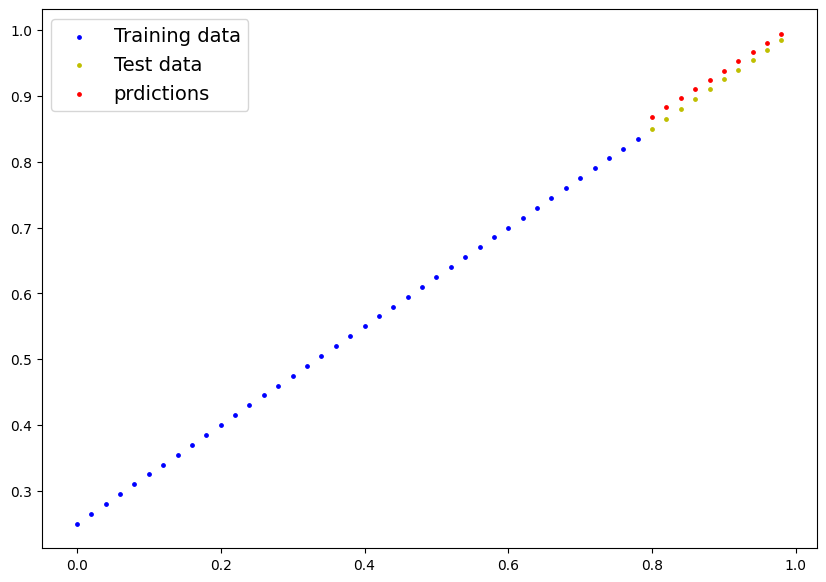

In [ ]:
# make predictions

model_1.eval()

with torch.inference_mode():
  y_pred=model_1(X_test)

plot_predictions(predictions=y_preds)

### 4. saving and loading a model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
# Load a PyTorch model

# Create a new instance of lienar regression model V2
loaded_model_1 = LinearRegressionModel2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModel2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)